# Explain Convolutional Neural Networks with SHAP | Better Data Science

-  This notebook trains a basic MNIST digit classifier with PyTorch and uses SHAP to interpret predictions

- Here are the library imports:

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

<br>

- Set `device` to `cpu` if you don't have a GPU

In [2]:
batch_size = 128
num_epochs = 5
device = torch.device('cuda:0')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

<br>

- The following cell downloads and transforms the dataset into an appropriate format

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])

train_set = datasets.MNIST('data/', train=True, download=True, transform=transform)
test_set = datasets.MNIST('data/', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


<br>

- Model training:

In [5]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359512
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.265772
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.846032
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.575709
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.639883

Test set: Average loss: 0.0024, Accuracy: 9434/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.537941
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.294185
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.289517
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.389934
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.382808

Test set: Average loss: 0.0013, Accuracy: 9604/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.194136
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.165671
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.331814
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.290340
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.172147

Test set: Average loss: 0.0010, Accuracy: 9695/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.209068
Train Epoch: 4 [12800/60000 (21%)]	Lo

<br>

## Explanations

In [6]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [7]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

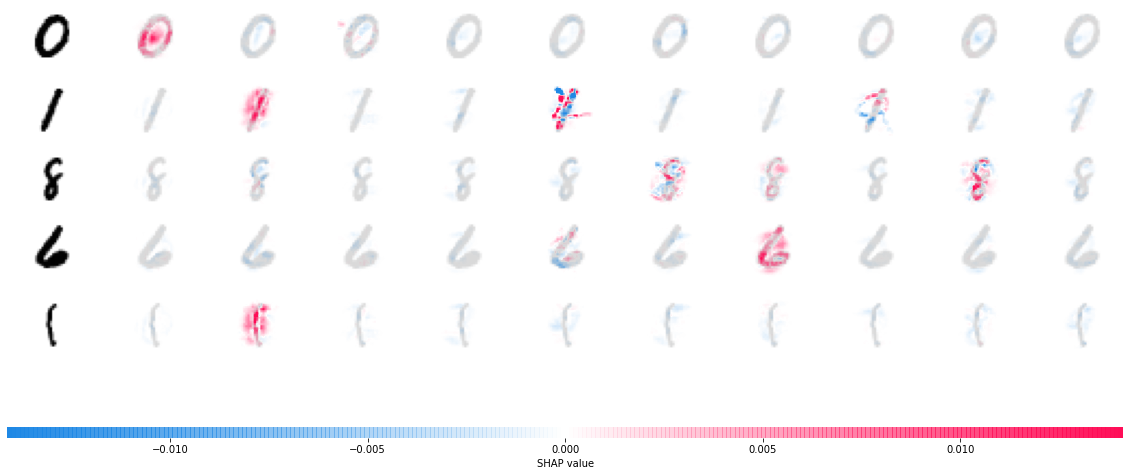

In [8]:
shap.image_plot(shap_numpy, -test_numpy)